
## 1. Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 2. Dataset load

In [2]:
#FILE_NAME = "train_subset_1000.txt"
#FILE_NAME = "train_subset_2500.txt"
#FILE_NAME = "train_subset_5000.txt"
FILE_NAME = "train.txt"
file = open(FILE_NAME, "r", encoding="utf-8")
data = file.readlines()

data = [i.split("\t") for i in data]

df = [[row[2], row[4]] for row in data]  # Extract 2nd and 4th elements
df = pd.DataFrame(df, columns = ['genre', 'plot'])
print(df.head())


     genre                                               plot
0  romance  Sekhar (Tarun) is a graduate from IIM and work...
1   horror  Kris Fowles (Katie Cassidy) goes to the Spring...
2   horror  Cynthia is traumatized by the death of her bab...
3    crime  Four friends, Gangu (Jackie Shroff), Abdul (Na...
4    drama  Crisis in a middle-class family when the son f...


## 3. Pre-processing

In [3]:
porter_stemmer=PorterStemmer()
def processSentence(s):
    words=re.split("\\s+",s)
    stemmed_words=[porter_stemmer.stem(word=w) for w in words]
    return ' '.join(stemmed_words)

x_processed = [processSentence(x) for x in df["plot"]]

labels = np.unique(df["genre"]).tolist()

print(labels)


['action', 'animation', 'comedy', 'crime', 'drama', 'horror', 'romance', 'sci-fi', 'western']


## 4. Create Vectors

In [4]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words='english', min_df=0.001, max_features=2500)
count_vectorizer = CountVectorizer(ngram_range=(1,3), stop_words ='english', min_df=0.001, max_features=2500)

X = tfidf_vectorizer.fit_transform(x_processed).toarray()
Z = count_vectorizer.fit_transform(x_processed).toarray()

## Train/test split


In [5]:
indices = range(len(df))
print(indices)
train_indices, test_test, y_train, y_test = train_test_split(indices, df["genre"], test_size=0.2, random_state=42)

X_train,X_test = X[train_indices],X[test_test]
Z_train,Z_test = Z[train_indices],Z[test_test]

range(0, 8041)


## Train with classic classifiers

In [6]:
from sklearn.multiclass import OneVsRestClassifier

print("==== SVM ====")
clf = OneVsRestClassifier(svm.SVC(kernel='linear')) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

print("Resultados com tfidf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred = y_pred, y_true = y_test, labels=labels, zero_division=1.))


==== SVM ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.59      0.59      0.59       202
   animation       0.80      0.68      0.74       115
      comedy       0.48      0.48      0.48       223
       crime       0.62      0.40      0.49       108
       drama       0.51      0.56      0.53       319
      horror       0.73      0.83      0.78       223
     romance       0.59      0.52      0.55       186
      sci-fi       0.50      0.44      0.47        39
     western       0.86      0.93      0.89       194

    accuracy                           0.63      1609
   macro avg       0.63      0.60      0.61      1609
weighted avg       0.63      0.63      0.62      1609



In [7]:
# Print available classes
for idx, class_names in enumerate(clf.classes_):
    print(f"==== {class_names} ====")
    class_coefficients = clf.estimators_[idx].coef_[0]
    
    feature_importance = list(zip(tfidf_vectorizer.get_feature_names_out(), class_coefficients))
    sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    top_n = 10
    most_important_features = sorted_features[:top_n]
    for feature, importance in most_important_features:
        print(f"{feature}: {importance}")


==== action ====
cia: 2.7923829755217957
kill: 2.701821855966584
fight: 2.3750942686169987
kidnap: 2.1631811264717946
cop: 2.1230945387169684
reveng: 2.0972092253713055
terrorist: 2.0508697248581806
elimin: 1.9570557213731599
polic: 1.9259134378371845
prakash: 1.8649323375199616
==== animation ====
bug: 2.830805553679082
kill: -2.186181589488484
anim: 2.177792745871863
daffi: 2.071025763502408
conan: 1.9910969393894336
cat: 1.9858710388558976
king: 1.5531344461322938
donald: 1.5382186771884032
herd: 1.461714884923054
jerri: 1.4182401505315023
==== comedy ====
kill: -2.8171832192004294
cloth: 2.1140595731865655
harold: 2.0708531670354366
party: 2.054482598248026
policeman: 1.9584645118058088
riley: 1.8334693448859765
death: -1.7635435418823648
murder: -1.7550308372492727
drunk: 1.7514733511483533
dead: -1.7321835129651337
==== crime ====
crimin: 2.2433982845986344
detect: 2.1114409527603786
suspect: 1.9547615768406845
murder: 1.8879210476908495
dead: 1.8559692642753678
polic: 1.78169920

## Plot the Confusion Matrices

In [8]:
predictions = clf.predict(X_test)

Genre: action | accuracy: 89.68%
Genre: animation | accuracy: 96.52%
Genre: comedy | accuracy: 85.71%
Genre: crime | accuracy: 94.34%
Genre: drama | accuracy: 80.48%
Genre: horror | accuracy: 93.35%
Genre: romance | accuracy: 90.18%
Genre: sci-fi | accuracy: 97.58%
Genre: western | accuracy: 97.33%


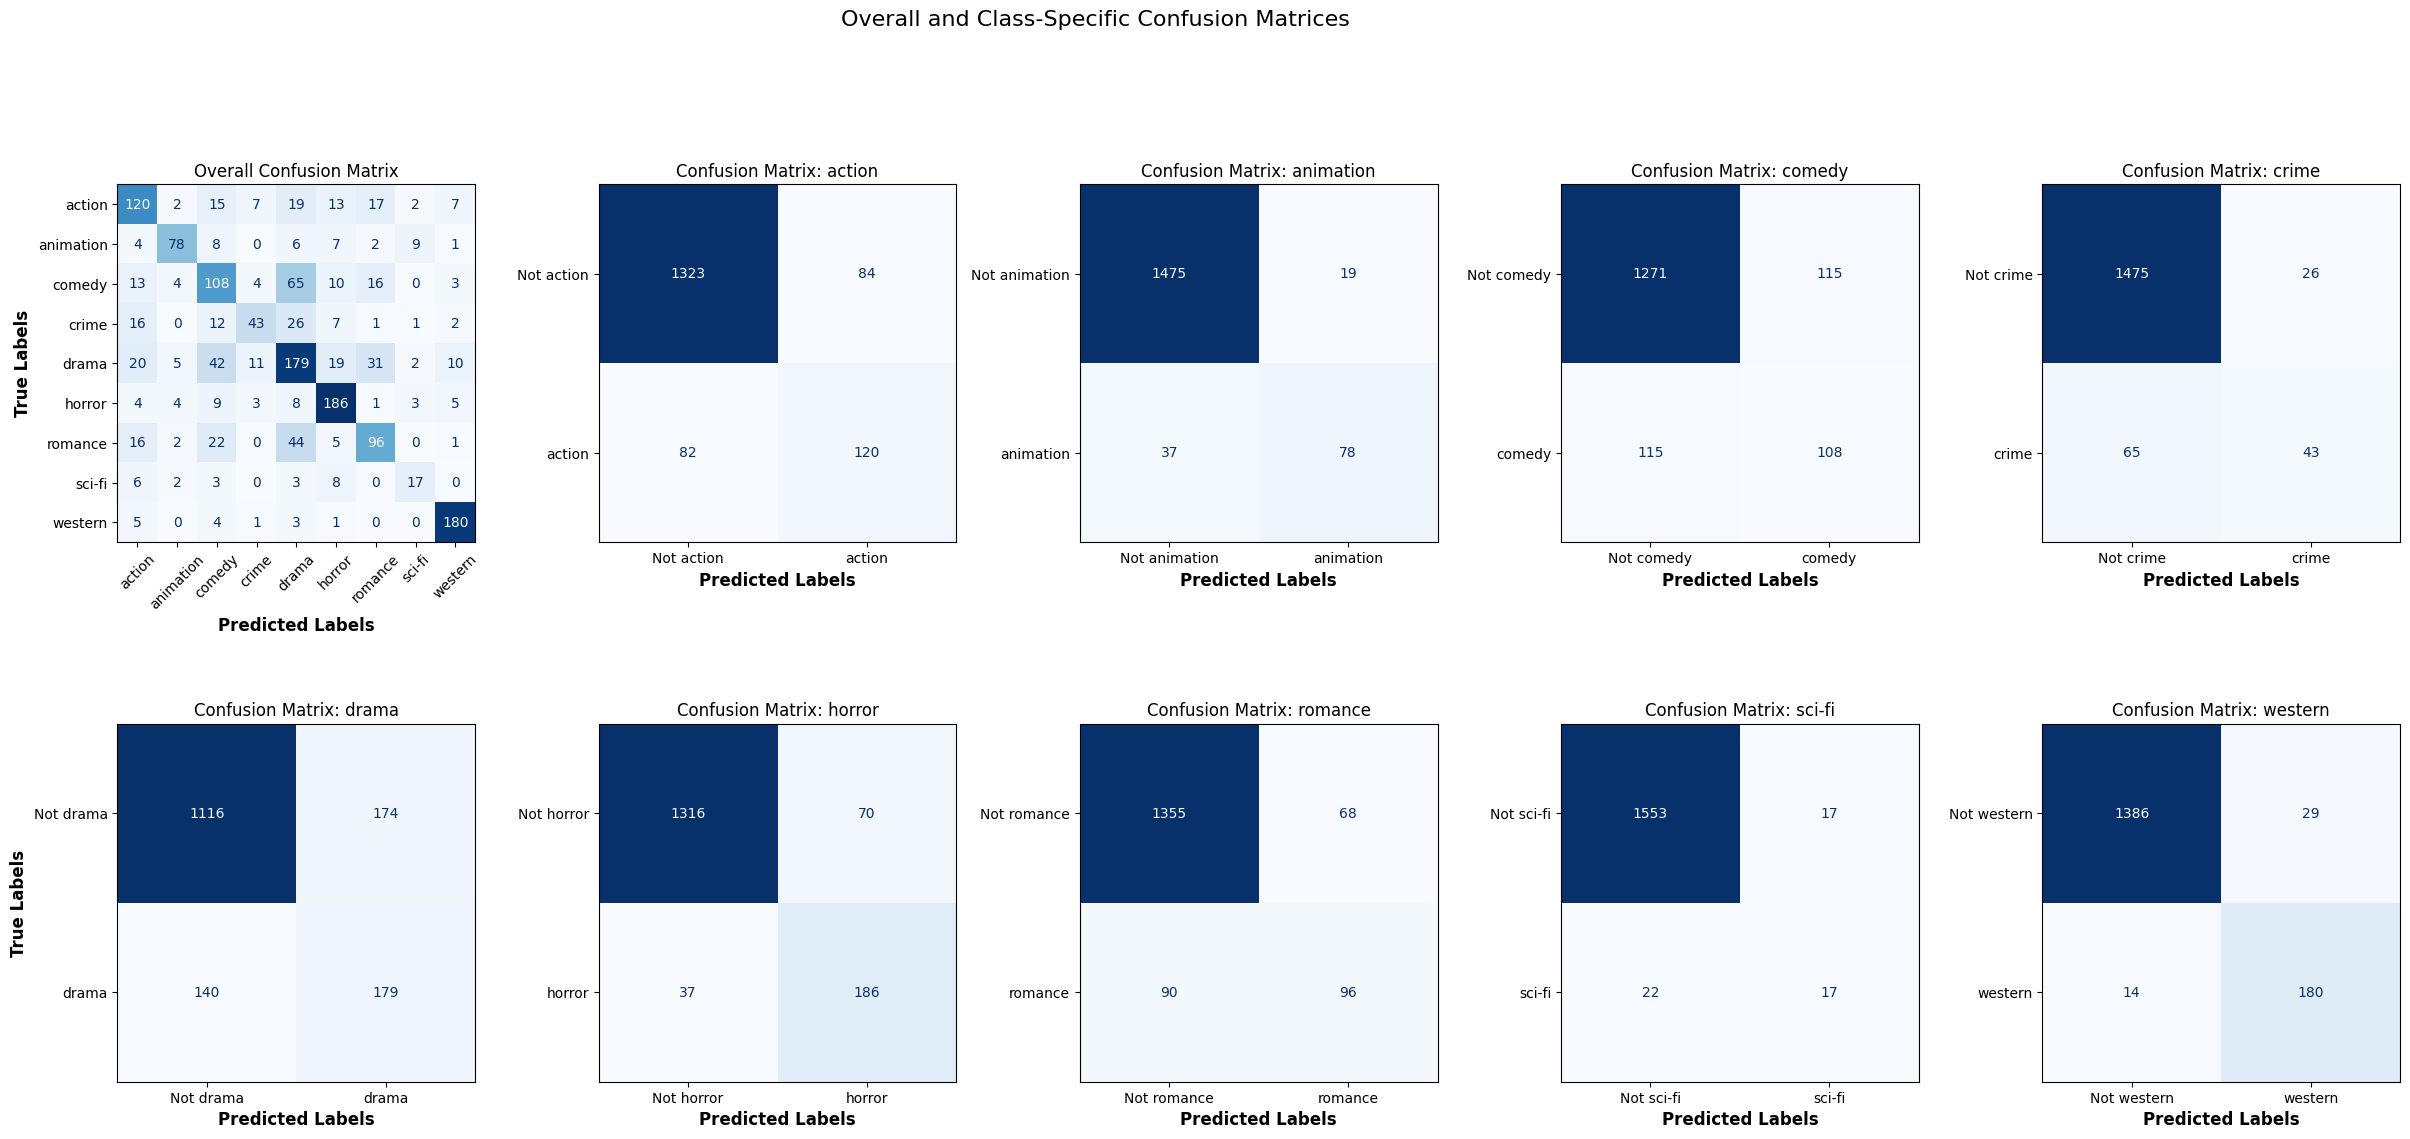

In [11]:

cm = confusion_matrix(y_test, predictions, labels=labels)
num_genres = len(labels)

# Create figure and subplots for overall and genre-specific matrices
fig, axes = plt.subplots(2, (num_genres + 1) // 2, figsize=(22, 12))
fig.suptitle("Overall and Class-Specific Confusion Matrices", fontsize=16)

# Plot overall confusion matrix on the first subplot
ax_overall = axes[0, 0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax_overall, xticks_rotation=45, colorbar=False)
ax_overall.set_title("Overall Confusion Matrix")

# Plot individual confusion matrices for each genre
for idx, genre in enumerate(labels):
    # Create binary confusion matrix for the current genre
    binary_true = [1 if label == genre else 0 for label in y_test]
    binary_pred = [1 if label == genre else 0 for label in predictions]
    class_cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1])

    # Calculate the correct subplot position
    row = (idx + 1) // ((num_genres + 1) // 2)
    col = (idx + 1) % ((num_genres + 1) // 2)
    ax = axes[row, col]
    
    # Calculate accuracy for the current genre
    accuracy = class_cm.diagonal().sum() / class_cm.sum()
    print(f"Genre: {genre} | accuracy: {accuracy:.2%}")
    

    # Plot the genre-specific confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=class_cm, display_labels=[f"Not {genre}", genre])
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix: {genre}")

    # Hide tick labels for clarity (except first in each row)
    if col != 0:  # Not the first column, hide y-axis labels
        ax.set_ylabel('')
        ax.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
    if col == 0 and row == 1:
        ax.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Labels", fontsize=12, fontweight='bold')
    
ax_overall.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
ax_overall.set_ylabel("True Labels", fontsize=12, fontweight='bold')
# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1.1, 0.95])
plt.show()



194


## Perform Kfold Cross-Validation on Train Set

In [29]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Initialize k-Fold Cross-Validation
k = 5  # Set number of folds
random_state = 42
kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

# Initialize dictionary to store results
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f1': make_scorer(f1_score, average='weighted', zero_division=1)
}

# Perform k-fold cross-validation using cross_validate
results = cross_validate(clf, X, df['genre'], cv=kf, scoring=scoring, return_train_score=True)

# Display results for each metric
print(f"Accuracy: {results['test_accuracy'].mean()} ± {results['test_accuracy'].std()}")
print(f"Precision: {results['test_precision'].mean()} ± {results['test_precision'].std()}")
print(f"Recall: {results['test_recall'].mean()} ± {results['test_recall'].std()}")
print(f"F1-Score: {results['test_f1'].mean()} ± {results['test_f1'].std()}")

Accuracy: 0.6285293544706547 ± 0.0105743257749004
Precision: 0.6234259060611165 ± 0.010271812187722332
Recall: 0.6285293544706547 ± 0.0105743257749004
F1-Score: 0.6232371566892458 ± 0.010702919056100267


## Compare with Test Set and Save Results

In [30]:
# Load test data (without genre labels)
test_file = open("test_no_labels.txt", "r", encoding="utf-8")
test_data = test_file.readlines()

# Preprocess the test data similar to the training data
x_test_no_labels_processed = [processSentence(x) for x in test_data]

# Transform the test data into TF-IDF vectors
X_test_no_labels = tfidf_vectorizer.transform(x_test_no_labels_processed).toarray()

# Predict the genres for the test data
y_pred_test_no_labels = clf.predict(X_test_no_labels)

# Save the predictions to a file
with open("results.txt", "w", encoding="utf-8") as results_file:
    for prediction in y_pred_test_no_labels:
        results_file.write(prediction + "\n")